In [32]:
# Import required libraries
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pydotplus
import graphviz
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pathlib import Path
import pickle

In [2]:
ACTIONS = ["End", "Normal", "Paper Swap", "Side Glance"]
SEQUENCE_LEN = 30
NUM_SEQUENCES = 20
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [9]:
# Mediapipe functions
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

# Draw landmarks
def draw_landmarks(image, results):
    # Face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    
# Extract keypoints function
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Video capture function
def video_capture():
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
    fps = cap.get(cv2.CAP_PROP_FPS)
    return cap

# Test landmarks function
def test_landmarks():
    cap = video_capture()
    
    with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
        while cap.isOpened():
            
            # Read feed
            ret, frame = cap.read()
            if not ret:
                continue
            
            # Make detection
            image, results = mediapipe_detection(frame, holistic)
            
            # Draw landmarks
            draw_landmarks(image, results)
            
            # Show to the screen
            cv2.imshow('OpenCV Feed', image)
            
            # Break (press q to quit)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()
    
# Data collection functions
# Scans the base folder for numeric subfolders, finds the next available integer, and returns the new path
def get_next_data_batch_path(base_path):
    existing = [int(name) for name in os.listdir(base_path) if name.isdigit()]
    next_id = max(existing) + 1 if existing else 1
    return os.path.join(base_path, str(next_id))

# Creates a new batch folder, with all subfolders set up
def setup_collection_dirs(base_path):
    new_batch_path = get_next_data_batch_path(base_path)
    for action in ACTIONS:
        for seq in range(NUM_SEQUENCES):
            os.makedirs(os.path.join(new_batch_path, action, str(seq)), exist_ok = True)
    return new_batch_path

# Collect keypoints from webcam and save .npy files
def collect_keypoints_to_path(save_path):
    with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
        cap = video_capture()
        for action in ACTIONS:
            for sequence in range(NUM_SEQUENCES):
                for frame_num in range(SEQUENCE_LEN):
                    ret, frame = cap.read()
                    image, results = mediapipe_detection(frame, holistic)
                    draw_landmarks(image, results)

                    # Display info
                    if frame_num == 0:
                        cv2.putText(image, f'Starting {action} #{sequence}', (65,200),
                                    cv2.FONT_HERSHEY_SIMPLEX, 3, (0,255,0), 8, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(2000)
                    else:
                        cv2.putText(image, f'{action} #{sequence}', (30,40),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)

                    # Save the keypoints
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(save_path, action, str(sequence), f"{frame_num}.npy")
                    np.save(npy_path, keypoints)

                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        cap.release()
                        cv2.destroyAllWindows()
                        return

        cap.release()
        cv2.destroyAllWindows()
        
# Data loading functions
def create_configs():
    project_root = Path.cwd().parent
    base_path = project_root / "Actions Dataset"
    batch_configs = []
    for folder in sorted(base_path.iterdir()):
        if folder.is_dir() and folder.name.isdigit():
            first_action_dir = folder / ACTIONS[0]
            if first_action_dir.exists():
                num_seq = len([seq for seq in first_action_dir.iterdir() if seq.is_dir()])
                batch_configs.append({"path": folder, "num_seq": num_seq})
    return batch_configs

def setup_action_dirs(configs):
    for config in configs:
        path = config["path"]
        num_seq = config["num_seq"]
        for action in ACTIONS:
            for seq in range(num_seq):
                os.makedirs(os.path.join(path, action, str(seq)), exist_ok=True)

def load_sequence_data(configs):
    label_map = {label: idx for idx, label in enumerate(ACTIONS)}
    all_sequences, all_labels = [], []

    for config in configs:
        path = config["path"]
        num_sequences = config["num_seq"]

        for action in ACTIONS:
            for seq_idx in range(NUM_SEQUENCES):
                window = []
                for frame_idx in range(SEQUENCE_LEN):
                    file_path = os.path.join(path, action, str(seq_idx), f"{frame_idx}.npy")
                    res = np.load(file_path)
                    window.append(res)
                all_sequences.append(window)
                all_labels.append(label_map[action])
    
    return np.array(all_sequences), np.array(all_labels)

def load_data():
    batch_configs = create_configs()
    setup_action_dirs(batch_configs)
    X, y = load_sequence_data(batch_configs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return X_train, y_train, X_test, y_test

# Build RNN-LTSM model function
def build_and_compile_model():
    model = tf.keras.models.Sequential([
    LSTM(64, return_sequences = True, activation = 'relu', input_shape = (30, 1662)),
    LSTM(32, return_sequences = False),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(len(ACTIONS), activation = 'linear')
    ])
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0007),
                  loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
                  metrics = ['categorical_accuracy'])
    return model

# Test function
def test_model(model):
    logits = model(X_test)
    yhat = tf.nn.softmax(logits)
    predictions = np.argmax(yhat, axis=1).tolist()
    ytrue = np.argmax(y_test, axis=1).tolist()
    print('Test Accuracy: ' + str(accuracy_score(ytrue, predictions)))
    
# Real-time test function
def test_real_time(lstm):
    sequence, sentence, acts, predictions, threshold = [], [], [], [], 0.5
    cap = video_capture()
    
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while 'End' not in acts:
    
            # Read feed
            ret, frame = cap.read()
    
            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            
            # Draw landmarks
            draw_landmarks(image, results)
            
            # Prediction
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]
            
            if len(sequence) == 30:
                logits = lstm(np.expand_dims(sequence, axis = 0))[0]
                res = tf.nn.softmax(logits)
                predictions.append(np.argmax(res))
                
            # Visualizations
                if np.unique(predictions[-10:])[0] == np.argmax(res): 
                    if res[np.argmax(res)] > threshold:    
                        
                        if len(sentence) > 0: 
                            if ACTIONS[np.argmax(res)] != sentence[-1]:
                                acts.append(sentence[-1])
                                sentence.append(ACTIONS[np.argmax(res)])
                        else:
                            sentence.append(ACTIONS[np.argmax(res)])
                            acts.append(sentence[-1])
    
                if len(sentence) > 5: 
                    sentence = sentence[-5:]
                    
                image = prob_viz(res, ACTIONS, image)
                
            cv2.rectangle(image, (0,0), (2496, 40), (90, 77, 43), -1)
            cv2.putText(image, '  '.join(sentence), (3,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Show to screen
            cv2.imshow('OpenCV Feed', image)
    
            # Break
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()
        
# Extract info function
def extract_info(acts):
    paper_swap = 0
    side_glance = 0
    
    for act in acts:
        if act == "Paper Swap":
            paper_swap += 1
        elif act == "Side Glance":
            side_glance += 1
    return paper_swap, side_glance

# Visualization function
def prob_viz(res, actions, input_frame):
    colors = [(125, 142, 91), (85, 43, 90), (89, 162, 244), (81, 75, 188)]
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60 + num * 38), (int(prob * 220), 95 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255 ,255 ,255), 2, cv2.LINE_AA)    
    return output_frame

# Prediction function
def pred(record, d_tree):
    if d_tree.predict(record) == 1:
        return 'unfortunately, is suspicious of cheating!'
    else:
        return 'is not suspicious of cheating.'
    
# Save lstm function
def save_lstm_model(lstm, lstm_file_name):
    project_root = Path.cwd().parent
    base_path = project_root / "Models"
    lstm.save(base_path / lstm_file_name)
    
# Load lstm function
def load_lstm(lstm_file_name):
    project_root = Path.cwd().parent
    base_path = project_root / "Models"
    lstm = tf.keras.models.load_model(base_path / lstm_file_name)
    return lstm

# Load decision tree function
def load_decision_tree(decision_tree_file_name):
    project_root = Path.cwd().parent
    base_path = project_root / "Models"
    d_tree = pickle.load(open(base_path / decision_tree_file_name, "rb"))
    return d_tree

In [4]:
# Test landmarks
test_landmarks()

In [5]:
# Collect data
project_root = Path.cwd().parent
base_path = project_root / "Actions Dataset"
new_batch_path = setup_collection_dirs(base_path)

# Start collecting and saving keypoints
collect_keypoints_to_path(new_batch_path)

In [7]:
# Load the data and train the model
X_train, y_train, X_test, y_test = load_data()
model = build_and_compile_model()
model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))

In [8]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 458,852
Trainable params: 458,852
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Test in real-world!
lstm = load_lstm("my_lstm.h5")
test_real_time(lstm)

In [30]:
# 10 Steps to start an exam!
def start_exam(lstm, d_tree):
    # 1. Staring
    print('###################### Exam ######################\n')
    
    # 2. Input Name and average previous scores
    name = input('Please enter your name: ')
    av_prev_score = float(input('Please enter average of your previous scores: '))
    
    # 3. Countdown
    t = 5
    print('\nThe exam will be started in:')
    while t + 1:
        timer = '{:02d} Seconds'.format(t)
        print(timer)
        time.sleep(1)
        t -= 1
    print('\nStart!')

    # 4. Open camera
        # Define variables
    sequence, sentence, acts, predictions, threshold = [], [], [], [], 0.5
    actions = np.array(['Normal', 'Paper Change', 'Look Aside', 'End']) 
        
        # Video capture
    cap = video_capture()

        # Start time measurement
    start = time.time()  
        # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
        while 'End' not in acts:
            # Read feed
            ret, frame = cap.read()
            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            # Draw landmarks
            draw_landmarks(image, results)
            # Prediction
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]
            if len(sequence) == 30:
                logits = lstm(np.expand_dims(sequence, axis = 0))[0]
                res = tf.nn.softmax(logits)
                predictions.append(np.argmax(res))
            # Visualizations
                if np.unique(predictions[-10:])[0] == np.argmax(res): 
                    if res[np.argmax(res)] > threshold:    
                        if len(sentence) > 0: 
                            if ACTIONS[np.argmax(res)] != sentence[-1]:
                                acts.append(sentence[-1])
                                sentence.append(ACTIONS[np.argmax(res)])
                        else:
                            sentence.append(ACTIONS[np.argmax(res)])
                            acts.append(sentence[-1])
                if len(sentence) > 5: 
                    sentence = sentence[-5:]
                image = prob_viz(res, ACTIONS, image)
            cv2.rectangle(image, (0,0), (2496, 40), (90, 77, 43), -1)
            cv2.putText(image, '  '.join(sentence), (3,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            # Show to screen
            cv2.imshow('OpenCV Feed', image)

            # Break with typing 'q'
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()
        
    # 5. Calculate total time
    end = time.time()
    ans_time = round((end - start) / 60, 2)
    
    # 6. Extract informations from the video
    paper_swap, side_glance = extract_info(acts)
    
    # 7. Input score
    score = float(input('Please enter the score: '))
    
    # 8. Create info dataframe
    record = pd.DataFrame({
        'Av Prev Scores' : av_prev_score,
        'Paper Swap' : paper_swap,
        'Side Glance' : side_glance,
        'Score' : score,
        'Ans Time' : ans_time,
        'Score / Ans Time' : score / ans_time
        }, index = [0])
    
    # 9. Make prediction using decision tree
        # Final Prediction
    final_pred = pred(record, d_tree)
    
    # 10. Return all results
        # Co
    t = 5
    print('\n\nDone! results will be shown for you in:')
    while t + 1:
        timer = '{:02d} Seconds'.format(t)
        print(timer)
        time.sleep(1)
        t -= 1
        # Final status
    status = f"\n\n\n{name}'s test status: \nScore: {score}\n{name} has changed paper for --{paper_swap}-- time\s\nand looked aside for --{side_glance}-- time\s\n{name} finished the test in {ans_time} minutes\nThe score of this test is {score - av_prev_score} points different from {name}'s previous average scores.\n\nFinally, by detection of AI,\n{name} {final_pred}"
    
        # Prediction path plot
    columns = ['Av Prev Scores', 'Paper Swap', 'Side Glance', 'Score', 'Ans Time', 'Score / Ans Time', 'Cheat']
    dot_data = tree.export_graphviz(d_tree, out_file = None,
                                feature_names = columns[0 : 6],
                                class_names = ['Not Cheat', 'Cheat'],
                                filled = True, rounded = True,
                                impurity = False,
                                special_characters = True)
    graph = pydotplus.graph_from_dot_data(dot_data)

    for node in graph.get_node_list():
        if node.get_attributes().get("label") is None:
            continue
        if "samples = " in node.get_attributes()["label"]:
            labels = node.get_attributes()["label"].split("<br/>")
            for i, label in enumerate(labels):
                if label.startswith("samples = "):
                    labels[i] = "samples = 0"
            node.set("label", "<br/>".join(labels))
            node.set_fillcolor("white")
    samples = record
    decision_paths = d_tree.decision_path(samples)
    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]            
            node.set_fillcolor("lightgreen")
            labels = node.get_attributes()["label"].split("<br/>")
            for i, label in enumerate(labels):
                if label.startswith("samples = "):
                    labels[i] = "samples = {}".format(int(label.split("=")[1]) + 1)
            node.set("label", "<br/>".join(labels))
            # Final returns
    display(graphviz.Source(graph.to_string()))
    return status

###################### Exam ######################

Please enter your name: Erfan
Please enter average of your previous scores: 15

The exam will be started in:
05 Seconds
04 Seconds
03 Seconds
02 Seconds
01 Seconds
00 Seconds

Start!
Please enter the score: 15


Done! results will be shown for you in:
05 Seconds
04 Seconds
03 Seconds
02 Seconds
01 Seconds
00 Seconds


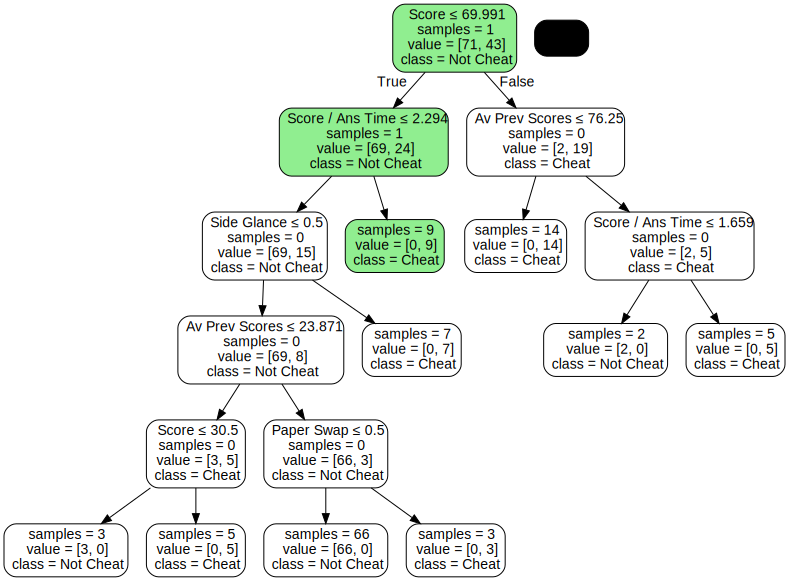




Erfan's test status: 
Score: 15.0
Erfan has changed paper for --0-- time\s
and looked aside for --0-- time\s
Erfan finished the test in 0.05 minutes
The score of this test is 0.0 points different from Erfan's previous average scores.

Finally, by detection of AI,
Erfan unfortunately, is suspicious of cheating!


In [33]:
# TIME TO TAKE AN EXAM!!!
lstm = load_lstm("lstm.h5")
d_tree = load_decision_tree("decision_tree.sav")
print(start_exam(lstm, d_tree))